In [277]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [278]:
import numpy as np
import matplotlib.pyplot as plt

import dedalus.public as d3

import logging
logger = logging.getLogger(__name__)

In [279]:
# parameters
N = 1.e-3 # buoyancy frequency
f = 5.e-5 # Coriolis parameter
θ = 2.e-3 # slope angle
κ0 = 5.e-5 # background diffusivity
κ1 = 5.e-3 # bottom enhancement of diffusivity
h = 250. # decay scale of mixing
σ = 1 # σandtl number
H = 3000. # domain height

In [280]:
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.complex128)

nz = 256*2 # number of grid points
zbasis = d3.Chebyshev(zcoord, size=nz, bounds=(0, H), dealias=3/2)

In [281]:
## Fields

# state variables
B = dist.Field(name='B', bases=zbasis)
U = dist.Field(name='U', bases=zbasis)
V = dist.Field(name='V', bases=zbasis)

# non-constant coefficients
κ = dist.Field(name='κ', bases=zbasis)
z = dist.local_grid(zbasis)
κ['g'] = κ0 + κ1*np.exp(-z/h)

Text(0, 0.5, '$z$ [m]')

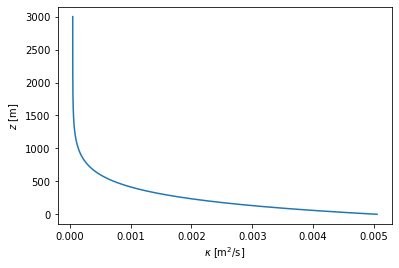

In [282]:
plt.plot(κ.data.real, z)
plt.xlabel(r"$\kappa$ [m$^{2}$/s]")
plt.ylabel(r"$z$ [m]")

In [283]:
# boundary conditions (tau method)
τ_B = dist.Field(name="τ_B")
τ_U = dist.Field(name="τ_U")
τ_V = dist.Field(name="τ_V")

τ_Bz = dist.Field(name="τ_Bz")
τ_Uz = dist.Field(name="τ_Uz")
τ_Vz = dist.Field(name="τ_Vz")

In [284]:
# substitutions
dz = lambda A: d3.Differentiate(A, zcoord)

cosθ = np.cos(θ)
sinθ = np.sin(θ)

lift_basis = zbasis.clone_with(a=1/2, b=1/2) # First derivative basis
lift = lambda A: d3.Lift(A, lift_basis, -1)
Uz = dz(U) + lift(τ_Uz)
Vz = dz(V) + lift(τ_Vz)
Bz = dz(B) + lift(τ_Bz)

noflux = dist.Field(name='noflux')
noflux['g'] = -N**2*cosθ

In [285]:
# Problem
problem = d3.LBVP([U, V, B, τ_U, τ_V, τ_B, τ_Uz, τ_Vz, τ_Bz], namespace=locals())

In [286]:
problem.add_equation("-f*V*cosθ - B*sinθ - σ*dz(κ*Uz) + lift(τ_U) = 0")
problem.add_equation("f*U*cosθ - σ*dz(κ*Vz) + lift(τ_V) = 0")
problem.add_equation("U*N**2*sinθ - dz(κ*Bz) + lift(τ_B) = dz(κ)*N**2*cosθ")
problem.add_equation('U(z=0) = 0')
problem.add_equation('V(z=0) = 0')
problem.add_equation('dz(B)(z=0) = noflux')
problem.add_equation('dz(U)(z=H) = 0')
problem.add_equation('dz(V)(z=H) = 0')
problem.add_equation('dz(B)(z=H) = 0')

# build solver and solve
solver = problem.build_solver()
solver.solve()

2022-02-15 10:48:17,931 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.2e+00/s


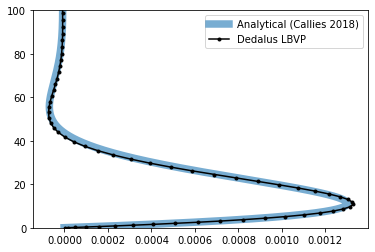

In [289]:
from bml_1d_LBVP_approx import *
bml = bbl_exp(k0=κ0, k1=κ1, h=h, N=N, f=f, θ=θ, H=H, dz=0.1)

plt.plot(bml['u'], bml['z'], label="Analytical (Callies 2018)", lw=7.5, alpha=0.6)
plt.plot(U['g'].real.data, z.data, "k.-", label="Dedalus LBVP")
plt.ylim(0, 100)
plt.legend()

In [ ]:
# along-slope wavenumbers
ll = np.logspace(-5, -2, 32) # [rad / m]

In [ ]:
# LINEAR STABILITY ANALYSIS

# variables
b = dist.Field(name='b', bases=zbasis)
u = dist.Field(name='u', bases=zbasis)
v = dist.Field(name='v', bases=zbasis)
w = dist.Field(name='w', bases=zbasis)
p = dist.Field(name='p', bases=zbasis)

# boundary conditions (tau method)
τ_b = dist.Field(name="τ_b")
τ_u = dist.Field(name="τ_u")
τ_v = dist.Field(name="τ_v")
τ_w = dist.Field(name="τ_w")
τ_p = dist.Field(name="τ_p")

# τ_Bz = dist.Field(name="τ_Bz")
# τ_Uz = dist.Field(name="τ_Uz")
# τ_Vz = dist.Field(name="τ_Vz")

# Eigenvalue
ω = dist.Field(name="ω")

problem = de.EVP(u, v, w, b, p, eigenvalue=ω)
problem.add_equation(('dt(u) + U*dx(u) + V*dy(u) + w*Uz - f*v*cos(θ) + dx(p)'
        '- b*sin(θ) - σ*(κ*dx(dx(u)) + κ*dy(dy(u)) + dz(κ)*uz'
        '+ κ*dz(uz)) = 0'))
problem.add_equation(('dt(v) + U*dx(v) + V*dy(v) + w*Vz + f*u*cos(θ)'
        '- f*w*sin(θ) + dy(p) - σ*(κ*dx(dx(v)) + κ*dy(dy(v))'
        '+ dz(κ)*vz + κ*dz(vz)) = 0'))
problem.add_equation(('dt(w) + U*dx(w) + V*dy(w) + f*v*sin(θ) + dz(p)'
        '- b*cos(θ) - σ*(κ*dx(dx(w)) - κ*dy(dy(w)) - dz(κ)*wz'
        '+ κ*dz(wz)) = 0'))
#problem.add_equation(('dt(b) + U*dx(b) + V*dy(b) + u*N**2*sin(θ)'
#        '+ w*(N**2*cos(θ) + Bz) - κ*dx(dx(b)) - κ*dy(dy(b)) - dz(κ)*bz'
#        '- κ*dz(bz) = 0'))
problem.add_equation(('dt(b) + U*dx(b) + V*dy(b) + u*(N**2*sin(θ)+cos(θ)/sin(θ)*Bz)'
        '+ w*(N**2*cos(θ) + Bz) - κ*dx(dx(b)) - κ*dy(dy(b)) - dz(κ)*bz'
        '- κ*dz(bz) = 0'))
problem.add_equation('dx(u) + dy(v) + wz = 0')
problem.add_equation('uz - dz(u) = 0')
problem.add_equation('vz - dz(v) = 0')
problem.add_equation('wz - dz(w) = 0')
problem.add_equation('bz - dz(b) = 0')
problem.add_bc('left(u) = 0')
problem.add_bc('left(v) = 0')
problem.add_bc('left(w) = 0')
problem.add_bc('left(bz) = 0')
problem.add_bc('right(uz) = 0')
problem.add_bc('right(vz) = 0')
problem.add_bc('right(w) = 0')
problem.add_bc('right(bz) = 0')

# set up solver
solver = problem.build_solver()
#%%
def sorted_eigen(k, l):

    """
    Solves eigenvalue problem and returns sorted eigenvalues and associated
    eigenvectors.
    """

    # set wavenumbers
    problem.namespace['k'].value = k
    problem.namespace['l'].value = l

    # solve problem
    solver.solve_dense(solver.pencils[0], rebuild_coeffs=True)

    # sort eigenvalues
    omg = solver.eigenvalues
    omg[np.isnan(omg)] = 0.
    omg[np.isinf(omg)] = 0.
    idx = np.argsort(omg.imag)

    return idx

def max_growth_rate(k, l):

    """Finds maximum growth rate for given wavenumbers k, l."""

    print(k, l)

    # solve eigenvalue problem and sort
    idx = sorted_eigen(k, l)

    return solver.eigenvalues[idx[-1]].imag

# get max growth rates
gr = np.array([max_growth_rate(0, l) for l in ll])

# get full eigenvectors and eigenvalues for l with largest growth
idx = sorted_eigen(0., ll[np.argmax(gr)])
solver.set_state(idx[-1])

# collect eigenvector
u = solver.state['u']
v = solver.state['v']
w = solver.state['w']
b = solver.state['b']

# shear production
SP = -2*np.real(np.conj(w['g'])*(u['g']*Uz['g']+v['g']*Vz['g']))

# buoyancy production
BP = 2*np.real((u['g']*np.sin(θ)+w['g']*np.cos(θ))*np.conj(b['g']))

# SAVE TO FILE

np.savez(name + '.npz', nz=nz, N=N, θ=θ, z=z, κ=κ['g'], σ=σ, U=U['g'],
        V=V['g'], B=B['g'], u=u['g'], v=v['g'], w=w['g'], b=b['g'], ll=ll,
        gr=gr, SP=SP, BP=BP)

# PLOTTING

# mean state

fig, ax = plt.subplots(1, 3, sharey=True)

ax[0].semilogx(κ['g'], z)
ax[0].set_xlabel('mixing coefficient [m$^2$/s]', va='baseline')
ax[0].set_ylabel('slope-normal coordinate [m]')
ax[0].get_xaxis().set_label_coords(.5, -.12)

ax[1].plot(U['g'].real, z)
ax[1].plot(V['g'].real, z)
ax[1].set_xlabel('mean flow [m/s]', va='baseline')
ax[1].get_xaxis().set_label_coords(.5, -.12)

ax[2].plot(N**2*np.cos(θ)*z + B['g'].real, z)
ax[2].set_xlabel('mean buoyancy [m/s$^2$]', va='baseline')
ax[2].get_xaxis().set_label_coords(.5, -.12)

#fig.savefig('fig/mean_state.pdf')

# energetics
#%%
plt.figure(figsize=(4.8, 4.8))
plt.semilogx(ll, gr)
plt.xlabel('along-track wavenumber [m$^{-1}$]')
plt.ylabel('growth rate')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.tight_layout()
#plt.savefig('fig/growth_rate.pdf')
#%%
plt.figure(figsize=(4.8, 4.8))
plt.plot(SP, z)
plt.plot(BP, z)
plt.xlabel('kinetic energy tendency [m$^2$/s$^3$]')
plt.ylabel('slope-normal coordinate [m]')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.legend(['shear production', 'buoyancy production'], frameon=False)
plt.tight_layout()
#plt.savefig('fig/energetics.pdf')

# most unstable mode

ly = np.linspace(0, 2*np.pi, nz)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6.4, 6.4))
im = ax[0,0].pcolormesh(ly, z, np.real(u['g'].reshape(nz, 1)
        * np.exp(1j*ly.reshape(1,nz))), rasterized=True, cmap='RdBu_r')
plt.colorbar(im, ax=ax[0,0])
ax[0,0].set_title('across-slope velocity')
im = ax[0,1].pcolormesh(ly, z, np.real(v['g'].reshape(nz, 1)
        * np.exp(1j*ly.reshape(1,nz))), rasterized=True, cmap='RdBu_r')
plt.colorbar(im, ax=ax[0,1])
ax[0,1].set_title('along-slope velocity')
im = ax[1,0].pcolormesh(ly, z, np.real(w['g'].reshape(nz, 1)
        * np.exp(1j*ly.reshape(1,nz))), rasterized=True, cmap='RdBu_r')
plt.colorbar(im, ax=ax[1,0])
ax[1,0].set_title('slope-normal velocity')
im = ax[1,1].pcolormesh(ly, z, np.real(b['g'].reshape(nz, 1)
        * np.exp(1j*ly.reshape(1,nz))), rasterized=True, cmap='RdBu_r')
plt.colorbar(im, ax=ax[1,1])
ax[1,1].set_title('buoyancy')
ax[0,0].set_xticks([0, np.pi, 2*np.pi])
ax[1,0].set_xlabel('phase')
ax[1,1].set_xlabel('phase')
ax[0,0].set_ylabel('slope-normal coordinate [m]')
ax[1,0].set_ylabel('slope-normal coordinate [m]')
#plt.savefig('fig/modes.pdf', dpi=300)

plt.show()